In [1]:
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt

# Setting up datasets

In [2]:
# Some starting code from Angel, mine required a 'seed' for training and eval datasets.
# Datasets going to training is roughly 70%.
new_kkanji_final_dataset_train = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/lyjohn/UCCS/Fall 2022/CS4820/Kuzushiji/final_dataset_150',
    validation_split=0.3,
    subset="training",
    image_size=(64, 64),
    batch_size=32,
    seed=132)

Found 70599 files belonging to 150 classes.
Using 49420 files for training.


In [3]:
# Datasets going to training is roughly 30%.
new_kkanji_final_dataset_val = tf.keras.utils.image_dataset_from_directory(
    'C:/Users/lyjohn/UCCS/Fall 2022/CS4820/Kuzushiji/final_dataset_150',
    validation_split=0.3,
    subset="validation",
    image_size=(64, 64),
    batch_size=32,
    seed=132)

Found 70599 files belonging to 150 classes.
Using 21179 files for validation.


In [4]:
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

new_kkanji_final_dataset_train = new_kkanji_final_dataset_train.map(process)
new_kkanji_final_dataset_val = new_kkanji_final_dataset_val.map(process)

# John's model

In [5]:
john_model = models.Sequential()
# Add a CNN layer with 32 filters, 3x3 kernel, and activation slope of 'relu'.
# Image dimensions will be 64x64.
john_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
# Use 2x2 pool to reduce size.
john_model.add(layers.AveragePooling2D((2, 2)))
john_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
john_model.add(layers.AveragePooling2D((2, 2)))
# Flatten the 2d to 1d layer.
john_model.add(layers.Flatten())
john_model.add(layers.Dense(64, activation='relu'))
# This number is related to the total number of options.
john_model.add(layers.Dense(150))

In [6]:
john_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

In [7]:
john_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                   metrics=['accuracy'])

# Really useful in stopping the training early when no more progress
# is made after a certain amount of epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

john_history = john_model.fit(new_kkanji_final_dataset_train, 
                              epochs=15, 
                              callbacks=callback, 
                              validation_data=new_kkanji_final_dataset_val)

Epoch 1/15
1545/1545 [==============================] - 84s 54ms/step - loss: 1.2744 - accuracy: 0.7102 - val_loss: 0.6412 - val_accuracy: 0.8372
Epoch 2/15
1545/1545 [==============================] - 92s 59ms/step - loss: 0.4123 - accuracy: 0.8955 - val_loss: 0.4890 - val_accuracy: 0.8767
Epoch 3/15
1545/1545 [==============================] - 91s 59ms/step - loss: 0.2389 - accuracy: 0.9368 - val_loss: 0.5117 - val_accuracy: 0.8799
Epoch 4/15
1545/1545 [==============================] - 97s 63ms/step - loss: 0.1433 - accuracy: 0.9598 - val_loss: 0.5578 - val_accuracy: 0.8789
Epoch 5/15
1545/1545 [==============================] - 97s 63ms/step - loss: 0.0970 - accuracy: 0.9706 - val_loss: 0.6233 - val_accuracy: 0.8839


## Evaluate John's Model 

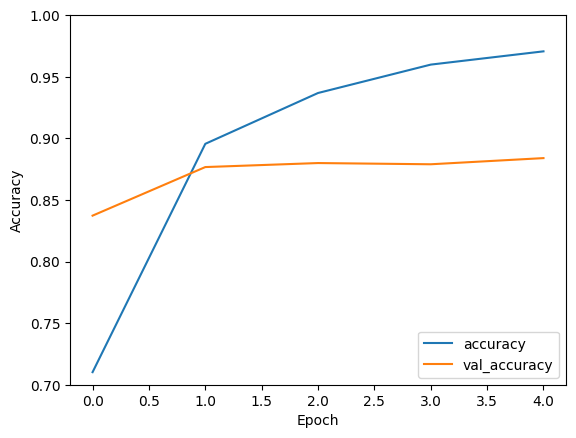

In [8]:
plt.plot(john_history.history['accuracy'], label='accuracy')
plt.plot(john_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.7, 1])
plt.legend(loc='lower right')


In [9]:
john_model.save('john_model')

INFO:tensorflow:Assets written to: john_model\assets


INFO:tensorflow:Assets written to: john_model\assets


In [10]:
john_model_load = models.load_model('john_model')

In [11]:
john_model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 average_pooling2d (AverageP  (None, 31, 31, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 14, 14, 64)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 64)                8

# Optuna

In [12]:
import numpy as np
import tensorflow as tf
import os
import optuna
import random

import matplotlib.pyplot as plt

from tensorflow.keras import layers, models

C:\Users\lyjohn\anaconda3\envs\CS4820_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = new_kkanji_final_dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = new_kkanji_final_dataset_train.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def objective(trial):
    first_layer_filter_num = trial.suggest_int('first_layer_filter_num', 8, 64)
    first_layer_kernel = trial.suggest_int('first_layer_kernel', 3, 4)
    first_layer_activation = trial.suggest_categorical('first_layer_activation', ['relu', 'sigmoid', 'tanh'])
    first_average_pooling_size = trial.suggest_int('first_average_pooling_size', 1, 4)
    second_layer_filter_num = trial.suggest_int('second_layer_filter_num', 8, 64)
    second_layer_kernel = trial.suggest_int('second_layer_kernel', 3, 4)
    second_layer_activation = trial.suggest_categorical('second_layer_activation', ['relu', 'sigmoid', 'tanh'])
    second_average_pooling_size = trial.suggest_int('second_average_pooling_size', 1, 4)
    dense_layer_size = trial.suggest_int('dense_layer_size', 4, 128)
    dense_layer_activation = trial.suggest_categorical('dense_layer_activation', ['relu', 'sigmoid', 'tanh'])
    
    model = models.Sequential()
    model.add(layers.Conv2D(first_layer_filter_num, (first_layer_kernel, first_layer_kernel), activation=first_layer_activation, input_shape=(64, 64, 3)))
    model.add(layers.AveragePooling2D((first_average_pooling_size, first_average_pooling_size)))
    model.add(layers.Conv2D(second_layer_filter_num, (second_layer_kernel, second_layer_kernel), activation=second_layer_activation))
    model.add(layers.AveragePooling2D((second_average_pooling_size, second_average_pooling_size)))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_layer_size, activation=dense_layer_activation))
    model.add(layers.Dense(150))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

    print(model.summary())

    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

    history = model.fit(train_ds, epochs=20,
                    callbacks=callback, validation_data=val_ds)

    return history.history['val_accuracy'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)
    

[I 2022-12-05 01:34:25,946] A new study created in memory with name: no-name-f9e7dde6-d434-4d11-8a83-6ea57565db49


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 61, 61, 34)        1666      
                                                                 
 average_pooling2d_2 (Averag  (None, 15, 15, 34)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 13)        7085      
                                                                 
 average_pooling2d_3 (Averag  (None, 4, 4, 13)         0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 208)               0         
                                                                 
 dense_2 (Dense)             (None, 33)               

[I 2022-12-05 01:53:47,526] Trial 0 finished with value: 0.9272966384887695 and parameters: {'first_layer_filter_num': 34, 'first_layer_kernel': 4, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 4, 'second_layer_filter_num': 13, 'second_layer_kernel': 4, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 3, 'dense_layer_size': 33, 'dense_layer_activation': 'relu'}. Best is trial 0 with value: 0.9272966384887695.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 61, 61, 45)        2205      
                                                                 
 average_pooling2d_4 (Averag  (None, 30, 30, 45)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 41)        29561     
                                                                 
 average_pooling2d_5 (Averag  (None, 6, 6, 41)         0         
 ePooling2D)                                                     
                                                                 
 flatten_2 (Flatten)         (None, 1476)              0         
                                                                 
 dense_4 (Dense)             (None, 35)               

[I 2022-12-05 02:29:50,869] Trial 1 finished with value: 0.9771954417228699 and parameters: {'first_layer_filter_num': 45, 'first_layer_kernel': 4, 'first_layer_activation': 'relu', 'first_average_pooling_size': 2, 'second_layer_filter_num': 41, 'second_layer_kernel': 4, 'second_layer_activation': 'relu', 'second_average_pooling_size': 4, 'dense_layer_size': 35, 'dense_layer_activation': 'relu'}. Best is trial 1 with value: 0.9771954417228699.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 20)        560       
                                                                 
 average_pooling2d_6 (Averag  (None, 15, 15, 20)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 12, 19)        6099      
                                                                 
 average_pooling2d_7 (Averag  (None, 6, 6, 19)         0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 684)               0         
                                                                 
 dense_6 (Dense)             (None, 82)               

[I 2022-12-05 03:07:11,574] Trial 2 finished with value: 0.9788344502449036 and parameters: {'first_layer_filter_num': 20, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 4, 'second_layer_filter_num': 19, 'second_layer_kernel': 4, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 2, 'dense_layer_size': 82, 'dense_layer_activation': 'relu'}. Best is trial 2 with value: 0.9788344502449036.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 12)        336       
                                                                 
 average_pooling2d_8 (Averag  (None, 15, 15, 12)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_9 (Conv2D)           (None, 12, 12, 33)        6369      
                                                                 
 average_pooling2d_9 (Averag  (None, 4, 4, 33)         0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 528)               0         
                                                                 
 dense_8 (Dense)             (None, 127)              

[I 2022-12-05 03:17:57,028] Trial 3 finished with value: 0.9784297943115234 and parameters: {'first_layer_filter_num': 12, 'first_layer_kernel': 3, 'first_layer_activation': 'relu', 'first_average_pooling_size': 4, 'second_layer_filter_num': 33, 'second_layer_kernel': 4, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 3, 'dense_layer_size': 127, 'dense_layer_activation': 'tanh'}. Best is trial 2 with value: 0.9788344502449036.


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 62, 62, 24)        672       
                                                                 
 average_pooling2d_10 (Avera  (None, 15, 15, 24)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_11 (Conv2D)          (None, 13, 13, 34)        7378      
                                                                 
 average_pooling2d_11 (Avera  (None, 6, 6, 34)         0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 1224)              0         
                                                                 
 dense_10 (Dense)            (None, 57)               

[I 2022-12-05 03:31:37,368] Trial 4 finished with value: 0.9609874486923218 and parameters: {'first_layer_filter_num': 24, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 4, 'second_layer_filter_num': 34, 'second_layer_kernel': 3, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 2, 'dense_layer_size': 57, 'dense_layer_activation': 'tanh'}. Best is trial 2 with value: 0.9788344502449036.


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 28)        784       
                                                                 
 average_pooling2d_12 (Avera  (None, 31, 31, 28)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 40)        10120     
                                                                 
 average_pooling2d_13 (Avera  (None, 29, 29, 40)       0         
 gePooling2D)                                                    
                                                                 
 flatten_6 (Flatten)         (None, 33640)             0         
                                                                 
 dense_12 (Dense)            (None, 6)                

[I 2022-12-05 03:38:32,584] Trial 5 finished with value: 0.02215702086687088 and parameters: {'first_layer_filter_num': 28, 'first_layer_kernel': 3, 'first_layer_activation': 'sigmoid', 'first_average_pooling_size': 2, 'second_layer_filter_num': 40, 'second_layer_kernel': 3, 'second_layer_activation': 'tanh', 'second_average_pooling_size': 1, 'dense_layer_size': 6, 'dense_layer_activation': 'tanh'}. Best is trial 2 with value: 0.9788344502449036.


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 61, 61, 51)        2499      
                                                                 
 average_pooling2d_14 (Avera  (None, 20, 20, 51)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_15 (Conv2D)          (None, 17, 17, 19)        15523     
                                                                 
 average_pooling2d_15 (Avera  (None, 8, 8, 19)         0         
 gePooling2D)                                                    
                                                                 
 flatten_7 (Flatten)         (None, 1216)              0         
                                                                 
 dense_14 (Dense)            (None, 66)               

[I 2022-12-05 11:34:49,990] Trial 6 finished with value: 0.9847227931022644 and parameters: {'first_layer_filter_num': 51, 'first_layer_kernel': 4, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 3, 'second_layer_filter_num': 19, 'second_layer_kernel': 4, 'second_layer_activation': 'relu', 'second_average_pooling_size': 2, 'dense_layer_size': 66, 'dense_layer_activation': 'sigmoid'}. Best is trial 6 with value: 0.9847227931022644.


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 62, 62, 53)        1484      
                                                                 
 average_pooling2d_16 (Avera  (None, 31, 31, 53)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 28)        23772     
                                                                 
 average_pooling2d_17 (Avera  (None, 14, 14, 28)       0         
 gePooling2D)                                                    
                                                                 
 flatten_8 (Flatten)         (None, 5488)              0         
                                                                 
 dense_16 (Dense)            (None, 62)               

[I 2022-12-05 12:17:34,845] Trial 7 finished with value: 0.9919465780258179 and parameters: {'first_layer_filter_num': 53, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 2, 'second_layer_filter_num': 28, 'second_layer_kernel': 4, 'second_layer_activation': 'relu', 'second_average_pooling_size': 2, 'dense_layer_size': 62, 'dense_layer_activation': 'relu'}. Best is trial 7 with value: 0.9919465780258179.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 56)        1568      
                                                                 
 average_pooling2d_18 (Avera  (None, 15, 15, 56)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_19 (Conv2D)          (None, 13, 13, 26)        13130     
                                                                 
 average_pooling2d_19 (Avera  (None, 13, 13, 26)       0         
 gePooling2D)                                                    
                                                                 
 flatten_9 (Flatten)         (None, 4394)              0         
                                                                 
 dense_18 (Dense)            (None, 37)               

[I 2022-12-05 12:26:18,138] Trial 8 finished with value: 0.025010118260979652 and parameters: {'first_layer_filter_num': 56, 'first_layer_kernel': 3, 'first_layer_activation': 'relu', 'first_average_pooling_size': 4, 'second_layer_filter_num': 26, 'second_layer_kernel': 3, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 1, 'dense_layer_size': 37, 'dense_layer_activation': 'relu'}. Best is trial 7 with value: 0.9919465780258179.


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 61, 61, 51)        2499      
                                                                 
 average_pooling2d_20 (Avera  (None, 61, 61, 51)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_21 (Conv2D)          (None, 59, 59, 11)        5060      
                                                                 
 average_pooling2d_21 (Avera  (None, 19, 19, 11)       0         
 gePooling2D)                                                    
                                                                 
 flatten_10 (Flatten)        (None, 3971)              0         
                                                                 
 dense_20 (Dense)            (None, 59)              

[I 2022-12-05 13:35:41,263] Trial 9 finished with value: 0.39012545347213745 and parameters: {'first_layer_filter_num': 51, 'first_layer_kernel': 4, 'first_layer_activation': 'sigmoid', 'first_average_pooling_size': 1, 'second_layer_filter_num': 11, 'second_layer_kernel': 3, 'second_layer_activation': 'sigmoid', 'second_average_pooling_size': 3, 'dense_layer_size': 59, 'dense_layer_activation': 'relu'}. Best is trial 7 with value: 0.9919465780258179.


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 average_pooling2d_22 (Avera  (None, 62, 62, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_23 (Conv2D)          (None, 59, 59, 58)        59450     
                                                                 
 average_pooling2d_23 (Avera  (None, 14, 14, 58)       0         
 gePooling2D)                                                    
                                                                 
 flatten_11 (Flatten)        (None, 11368)             0         
                                                                 
 dense_22 (Dense)            (None, 99)              

[I 2022-12-05 16:37:36,599] Trial 10 finished with value: 0.9992715716362 and parameters: {'first_layer_filter_num': 64, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 1, 'second_layer_filter_num': 58, 'second_layer_kernel': 4, 'second_layer_activation': 'relu', 'second_average_pooling_size': 4, 'dense_layer_size': 99, 'dense_layer_activation': 'sigmoid'}. Best is trial 10 with value: 0.9992715716362.


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 average_pooling2d_24 (Avera  (None, 62, 62, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_25 (Conv2D)          (None, 59, 59, 59)        60475     
                                                                 
 average_pooling2d_25 (Avera  (None, 14, 14, 59)       0         
 gePooling2D)                                                    
                                                                 
 flatten_12 (Flatten)        (None, 11564)             0         
                                                                 
 dense_24 (Dense)            (None, 101)             

[I 2022-12-05 19:29:30,347] Trial 11 finished with value: 0.9985228776931763 and parameters: {'first_layer_filter_num': 64, 'first_layer_kernel': 3, 'first_layer_activation': 'tanh', 'first_average_pooling_size': 1, 'second_layer_filter_num': 59, 'second_layer_kernel': 4, 'second_layer_activation': 'relu', 'second_average_pooling_size': 4, 'dense_layer_size': 101, 'dense_layer_activation': 'sigmoid'}. Best is trial 10 with value: 0.9992715716362.


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 62, 62, 64)        1792      
                                                                 
 average_pooling2d_26 (Avera  (None, 62, 62, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_27 (Conv2D)          (None, 59, 59, 61)        62525     
                                                                 
 average_pooling2d_27 (Avera  (None, 14, 14, 61)       0         
 gePooling2D)                                                    
                                                                 
 flatten_13 (Flatten)        (None, 11956)             0         
                                                                 
 dense_26 (Dense)            (None, 103)             

In [ ]:
print(f'Best trial info:\n{study.best_trial}\n')
for param, value in study.best_params.items():
    print(f'Param: {param}\tValue: {value}')